<a href="https://colab.research.google.com/github/MerkulovDaniil/optim/blob/master/assets/Notebooks/Line_search.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# General formulation
Suppose, we have a problem of minimization function $f(x): \mathbb{R} \to \mathbb{R}$ of scalar variable:
$$
f(x) \to \min_{x \in \mathbb{R}}
$$

Sometimes, we refer to the similar problem of finding minimum on the line segment $[a,b]$:

$$
f(x) \to \min_{x \in [a,b]}
$$

🤓 We'll compare ['random search', 'binary search', 'golden search', 'parabolic search'] on the Inverse Maxwell function on the [0, 6] interval
🤓 Random search: 80 function calls. 40 iterations. f = 0.71
🤓 Binary search: 23 function calls. 13 iterations. f = 0.71
🤓 Golden search: 20 function calls. 19 iterations. f = 0.71
🤓 Parabolic search: 17 function calls. 14 iterations. f = 0.71


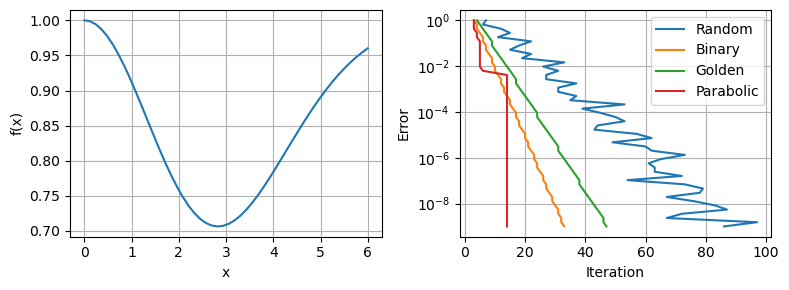

In [2]:
#@title Line search for unimodal functions. Optimizers comparison { run: "auto" }
# Need to implement brent method, but in scipy
# it has no callbacks right now :(
#===== Libraries =====#
from scipy.optimize import OptimizeResult
from scipy.optimize import minimize
import numpy as np
from matplotlib import pyplot as plt
import math

#===== Algorithms =====#
def callback(xk, f, funs, xs, loc_lens):
    funs.append(f(xk))
    xs.append(xk)
    loc_lens.append(x_b - x_a)

def random_bracket_line_search(fun, x0, args=(), maxfev=None,
        maxiter=100, callback=None, **options):
    tol, x_a, x_b = options['tol'], options['x_a'], options['x_b']
    x_best = x0
    funcalls = 0
    niter = 0
    stop = False
    success = False

    while not stop and niter < maxiter:
        improved = False
        niter += 1
        funcalls += 2
        
        x_guess_left    = np.random.uniform(x_a, x_b)
        x_guess_right   = np.random.uniform(x_a, x_b)
        x_guess_left, x_guess_right = min(x_guess_left, x_guess_right), max(x_guess_left, x_guess_right)
        f_guess_left    = fun(x_guess_left)
        f_guess_right   = fun(x_guess_right)

        if f_guess_left <= f_guess_right:
            x_b = x_guess_right
        else:
            x_a = x_guess_left

        x_best = (x_a + x_b)/2
        f_best = fun(x_best)
        
        if callback is not None:
            callback(x_best)
        
        if (x_b - x_a < tol):
            success = True

        if (maxfev is not None and funcalls >= maxfev) or (x_b - x_a < tol):
            stop = True
            break

        
    return OptimizeResult(fun=f_best, x=x_best, nit=niter,
                          nfev=funcalls, success=success)

def binary_search(fun, x0, args=(), maxfev=None,
        maxiter=100, callback=None, **options):
    tol, x_a, x_b = options['tol'], options['x_a'], options['x_b']
    x_best = x0
    funcalls = 1
    niter = 0
    stop = False
    success = False

    while not stop and niter < maxiter:
        niter += 1
        x_c = (x_a + x_b) / 2
        x_y = (x_a + x_c) / 2
        funcalls += 1
        if fun(x_y) <= fun(x_c):
            x_b = x_c
            x_c = x_y
        else:
            x_z = (x_b + x_c) / 2
            funcalls += 1
            if fun(x_c) <= fun(x_z):
                x_a = x_y
                x_b = x_z
            else:
                x_a = x_c
                x_c = x_z

        x_best = x_c
        f_best = fun(x_c)
        
        if callback is not None:
            callback(x_best)
        
        if (x_b - x_a < tol):
            success = True

        if (maxfev is not None and funcalls >= maxfev) or (x_b - x_a < tol):
            stop = True
            break

        
    return OptimizeResult(fun=f_best, x=x_best, nit=niter,
                          nfev=funcalls, success=success)

def golden_search(fun, x0, args=(), maxfev=None,
        maxiter=100, callback=None, **options):
    tol, x_a, x_b = options['tol'], options['x_a'], options['x_b']
    x_best = x0
    funcalls = 1
    niter = 0
    stop = False
    success = False

    while not stop and niter < maxiter:
        niter += 1
        tau = (np.sqrt(5) + 1) / 2.0
        x_y = x_a + (x_b - x_a) / tau**2
        x_z = x_a + (x_b - x_a) / tau
        funcalls += 1
        if fun(x_y) <= fun(x_z):
            x_b = x_z
            x_z = x_y
            x_y = x_a + (x_b - x_a) / tau**2
        else:
            x_a = x_y
            x_y = x_z
            x_z = x_a + (x_b - x_a) / tau

        x_best = x_z
        f_best = fun(x_z)
        
        if callback is not None:
            callback(x_best)
        
        if (x_b - x_a < tol):
            success = True

        if (maxfev is not None and funcalls >= maxfev) or (x_b - x_a < tol):
            stop = True
            break

    return OptimizeResult(fun=f_best, x=x_best, nit=niter,
                          nfev=funcalls, success=success)
    
def parabolic_search(fun, x0, args=(), maxfev=None,
        maxiter=100, callback=None, **options):
    tol, x_a, x_b = options['tol'], options['x_a'], options['x_b']
    x1, x2, x3 = x_a, (x_a + x_b)/2, x_b
    x_best = x2
    funcalls = 3
    niter = 0
    stop = False
    success = False

    f1, f2, f3 = fun(x1), fun(x2), fun(x3)

    while not stop and niter < maxiter:
        funcalls += 1
        niter += 1

        u = x2 - ((x2 - x1)**2*(f2 - f3) - (x2 - x3)**2*(f2 - f1))/(2*((x2 - x1)*(f2 - f3) - (x2 - x3)*(f2 - f1)))
        fu = fun(u)

        if x2 <= u:
            if f2 <= fu:
                x1, x2, x3 = x1, x2, u
                f1, f2, f3 = f1, f2, fu
            else:
                x1, x2, x3 = x2, u, x3
                f1, f2, f3 = f2, fu, f3
        else:
            if fu <= f2:
                x1, x2, x3 = x1, u, x2
                f1, f2, f3 = f1, fu, f2
            else:
                x1, x2, x3 = u, x2, x3
                f1, f2, f3 = fu, f2, f3

        x_best = (x1 + x3)/2

        if callback is not None:
            callback(x2)
        
        if (abs(x3 - x1) < tol):
            success = True

        if (maxfev is not None and funcalls >= maxfev) or (abs(x3 - x1) < tol):
            stop = True
            break

    return OptimizeResult(fun=fun(x_best), x=x_best, nit=niter,
                          nfev=funcalls, success=success)

#===== Functions =====#
# "sin(sin(sin(sqrt(x/2))))"
f_1 = lambda x: np.sin(np.sin(np.sin(np.sqrt(x/2)))) + 1

# 'Inverse Maxwell'
def inverse_maxwell(x, a):
    return -np.sqrt(2/math.pi) * x**2*np.exp(-x**2/(2*(a)**2))/(a)**3
f_2 = lambda x: inverse_maxwell(x, 2) + 1 

# "(x - 2) * x * (x + 2)**2 + 10"
f_3 = lambda x: (x - 2) * x * (x + 2)**2 + 10 

def callback(xk, f, funs, xs):
    funs.append(f(xk))
    xs.append(xk)
#===== Input reading =====#
optimizers = []
Random_bracket_search = True #@param {type:"boolean"}
Binary_search = True #@param {type:"boolean"}
Golden_search = True #@param {type:"boolean"}
Parabolic_search = True #@param {type:"boolean"}
if Random_bracket_search:
    optimizers.append('random search')
if Binary_search:
    optimizers.append('binary search')
if Golden_search:
    optimizers.append('golden search')
if Parabolic_search:
    optimizers.append('parabolic search')

Function = 'Inverse Maxwell' #@param ['Inverse Maxwell', "sin(sin(sin(sqrt(x/2))))", "(x - 2) * x * (x + 2)**2 + 10"] 
a = 0 #@param {type:"slider", min:-5, max:5, step:1}
b = 6 #@param {type:"slider", min:0, max:10, step:1}
tolerance = 1e-3
tolerances_bound =  1e-9#@param {type:"number"}
tolerances = np.logspace(np.log10(tolerances_bound), 0)
print(f"🤓 We'll compare {optimizers} on the {Function} function on the [{a}, {b}] interval")

if Function == 'Inverse Maxwell':
    func = f_2
elif Function == 'sin(sin(sin(sqrt(x/2))))':
    func = f_1
elif Function == '(x - 2) * x * (x + 2)**2 + 10':
    func = f_3

x = np.linspace(a,b)

# fig, [[ax1,ax2], ax3]  = plt.subplots(2, 2, figsize=(12,8))

fig = plt.figure(figsize = (8,3))
ax1 = plt.subplot(121)
ax2 = plt.subplot(122)
ax1.plot(x, func(x))
ax1.set_ylabel('f(x)')
ax1.set_xlabel('x')
ax1.grid()

x0 = (a+b)/2   

#===== Optimization =====#
for opt in optimizers:
    if opt == 'random search':
        x0 = (a+b)/2 
        funs_rbls = []
        xs_rbls = []
        n_it_rbls = []
        callback_rbls = lambda xk: callback(xk, func, funs_rbls, xs_rbls)
        res = minimize(func, x0, method=random_bracket_line_search, callback=callback_rbls, options={'maxiter': 100, 'tol': tolerance, 'x_a': a, 'x_b': b})
        print(f'🤓 Random search: {res.nfev} function calls. {res.nit} iterations. f = {funs_rbls[-1]:.2f}')
        for tolerance_ in tolerances:
            res = minimize(func, x0, method=random_bracket_line_search, callback=callback_rbls, options={'maxiter': 1000, 'tol': tolerance_, 'x_a': a, 'x_b': b})
            n_it_rbls.append(res.nit)
        ax2.semilogy(n_it_rbls, tolerances , label='Random')
    elif opt == 'binary search':
        x0 = (a+b)/2 
        funs_bs = []
        xs_bs = []
        n_it_bs = []
        callback_bs = lambda xk: callback(xk, func, funs_bs, xs_bs)
        res = minimize(func, x0, method=binary_search, callback=callback_bs, options={'maxiter': 100, 'tol': tolerance, 'x_a': a, 'x_b': b})
        print(f'🤓 Binary search: {res.nfev} function calls. {res.nit} iterations. f = {funs_rbls[-1]:.2f}')
        for tolerance_ in tolerances:
            res = minimize(func, x0, method=binary_search, callback=callback_bs, options={'maxiter': 1000, 'tol': tolerance_, 'x_a': a, 'x_b': b})
            n_it_bs.append(res.nit)
        ax2.semilogy(n_it_bs, tolerances, label='Binary')
    elif opt == 'golden search':
        x0 = (a+b)/2 
        funs_gs = []
        xs_gs = []
        n_it_gs = []
        callback_gs = lambda xk: callback(xk, func, funs_gs, xs_gs)
        res = minimize(func, x0, method=golden_search, callback=callback_gs, options={'maxiter': 100, 'tol': tolerance, 'x_a': a, 'x_b': b})
        print(f'🤓 Golden search: {res.nfev} function calls. {res.nit} iterations. f = {funs_rbls[-1]:.2f}')
        for tolerance_ in tolerances:
            res = minimize(func, x0, method=golden_search, callback=callback_gs, options={'maxiter': 1000, 'tol': tolerance_, 'x_a': a, 'x_b': b})
            n_it_gs.append(res.nit)
        ax2.semilogy(n_it_gs, tolerances, label='Golden')
    elif opt == 'parabolic search':
        x0 = (a+b)/2 
        funs_ps = []
        xs_ps = []
        n_it_ps = []
        callback_ps = lambda xk: callback(xk, func, funs_ps, xs_ps)
        res = minimize(func, x0, method=parabolic_search, callback=callback_ps, options={'maxiter': 100, 'tol': tolerance, 'x_a': a, 'x_b': b})
        print(f'🤓 Parabolic search: {res.nfev} function calls. {res.nit} iterations. f = {funs_rbls[-1]:.2f}')
        for tolerance_ in tolerances:
            res = minimize(func, x0, method=parabolic_search, callback=callback_ps, options={'maxiter': 1000, 'tol': tolerance_, 'x_a': a, 'x_b': b})
            n_it_ps.append(res.nit)
        ax2.semilogy(n_it_ps, tolerances, label='Parabolic')

ax2.set_ylabel('Error')
ax2.set_xlabel('Iteration')
ax2.grid()
ax2.legend()

fig.tight_layout()
plt.show()
